# Visualización de proyecto de detección de alimentos.

La visualización de datos se ha realizado con Tableau a partir de cuatro tablas: 

1)	***Detection***. Esta tabla contiene la información de todos los alimentos que se han detectado en las imágenes tomadas. Está compuesta por los siguientes campos:

•	*Id Detection*. Identificador de la imagen.

•	*Product*. Alimento que se ha detectado en la imagen.

•	*Qty Detected*. Cantidad de unidades detectadas de ese producto.

•	*Image Url*. Ruta de GCP donde se almacena la imagen con los elementos detectados.

•	Date Created. Fecha en la que se ha realizado la detección.

2)	***Equivalences***. En esta tabla se indica una estimación de la cantidad de piezas de cada producto que existen en una determinada cantidad de kilogramos. La componen los campos:

•	*Date Created*. Fecha en la que se ha realizado la equivalencia.

•	*Product*. Indica el alimento al que hace referencia la equivalencia.

•	*Qty Kg*. Cantidad en kilogramos.

•	*Qty Pieces*. Estimación del número de piezas existentes en los kilogramos indicados en el campo “Qty Kg”.

3)	***Shoplist***. Esta tabla contiene la lista con la cantidad de cada producto que el usuario quiere tener disponible en su frigorífico en cada determinada fecha. Está compuesta por:

•	*Date Created*. Fecha en la cual el usuario necesita tener el producto especificado.

•	*Product*. Alimento al que hace referencia.
•	*Qty Pieces Wished*. Cantidad de unidades que el usuario quiere tener de dicho producto en la fecha indicada.

4)	***Stores***. En esta tabla se almacenan los datos scrapeados de los productos con los precios de cada supermercado. Los campos que contiene son:

•	*Supermercado*. El nombre del supermercado.

•	*Tipo*. El tipo de producto.

•	*Fecha*.  La fecha en la que se ha realizado la captura.

•	*Categoria*. El nombre del producto.

•	*Category*. El nombre del producto en inglés.

•	*Subcategoría*. La variedad del producto.

•	*Precio*. El precio del producto.

•	*Peso Gr*. El peso del producto.

•	*Precio_kg*. El precio por kilogramo del producto.


En cuanto al dashboard, está compuesto por cinco hojas de trabajo, organizadas en tres secciones. 

1)	En la sección superior (“Food detected”), a la izquierda se muestran las fechas en las que se han realizado las imágenes del contenido del frigorífico para analizarlas. En la parte derecha se muestra la imagen resaltando los productos detectados. La hoja de trabajo de esta sección es “Detection”, y los datos se obtienen de la tabla “detection”. Esta hoja de trabajo actúa como filtro para el resto de secciones del dashboard, es decir, dependiendo del valor seleccionado en esta sección se filtra la información mostrada en el resto de secciones.
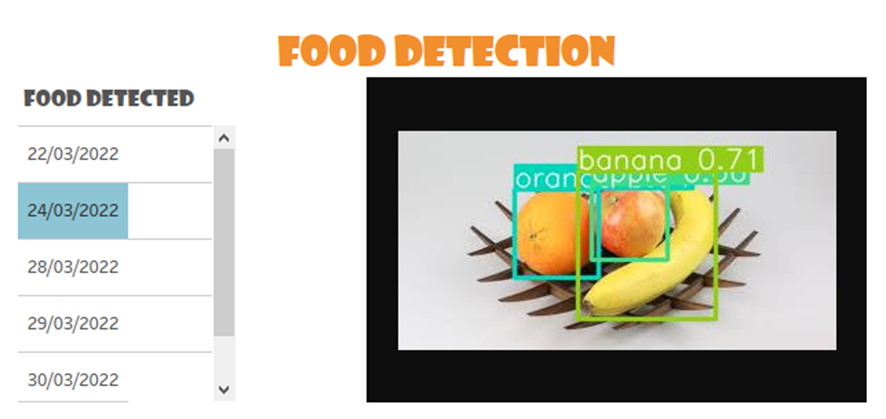

2)	La siguiente sección es “Shoping list”, y muestra, para cada fecha seleccionada en la sección superior, un gráfico de barras con i) la cantidad de productos detectados en la imagen (color naranja), ii) la cantidad de productos que quiere el usuario tener (colores naranja + verde), y iii) de la resta de estos dos valores se obtiene la cantidad de piezas de cada producto que se tienen que comprar (color verde). La hoja de trabajo de esta sección es “Shoplist_Graph”, y los datos se obtienen de la unión (left join) de las siguientes consultas SQL personalizadas mediante los campos “date_created” y “product”:

a.	*Shoplist_agregado*. En la que se agrupan los registros de la tabla “shoplist” por los campos “date_created” y “product” y se realiza el sumatorio de los valores del campo “qty_pieces_wished”.

*SELECT date_created, product, SUM(qty_pieces_wished) sum_qty_pieces_wished*

*FROM shoplist*

*GROUP BY date_created, producto*

b.	*Detection_agregado*. En la que se agrupan los registros de la tabla “detection” por los campos “Date_Created” y “Product” y se realiza el sumatorio de los valores del campo “Qty_Detected”.

*SELECT Date_Created, Product, SUM(Qty_Detected) sum_qty_detected*

*FROM detection*

*GROUP BY Date_Created, Product*

Además, se han creado los campos calculados:

•	“sum_qty_detected_nonulos”, en la que se sustituyen los valores nulos del campo “sum_qty_detected” por el valor 0 para evitar problemas en los cálculos.

•	“qty_to_buy”, que es el resultado de restar los valores de los campos “sum_qty_pieces_wished” y “sum_qty_detected_nonulos”, es decir, se restan la cantidad de piezas de productos que se tienen en el frigorífico a la cantidad deseada por el usuario, por lo que se obtiene la cantidad de piezas de productos que se tienen que comprar para que el usuario pueda disponer de la cantidad que necesita.

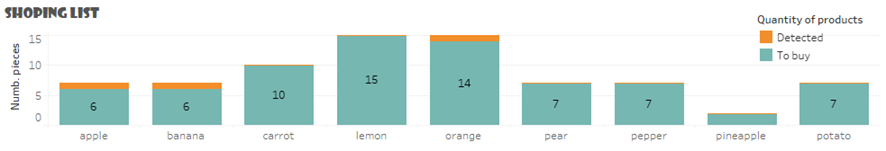



3)	La tercera y última sección es “Food prices”, en la que se muestran los precios tanto parciales por producto como el total de la compra para las cantidades de productos que se necesita adquirir. Los datos de los precios de los productos se han obtenido mediante scrapping de las páginas web de los supermercados Eroski y Carrefour. Por lo tanto, se muestran los precios desglosados por producto para estos dos supermercados en dos gráficas de barras horizontales, para que se puedan comparar los precios en ambos supermercados. También se muestra el precio total de la compra para cada supermercado. La hoja de trabajo en la que se detallan los precios de cada producto para los dos supermercados es “Price_E&C” y las hojas de trabajo de los precios totales de la compra son “Price_Total_Eroski” y “Price_Total_Carrefour”. Los datos se obtienen de las siguientes consultas SQL personalizadas:

a.	Unión (left join) de la siguiente consulta SQL personalizada “Carrefour_prices” con la tabla “equivalences” mediante el campo “producto”.

i.	Se filtran los registros del supermercado Carrefour y se selecciona el producto o categoría cuya variedad o subcategoría posea el menor precio.
*SELECT supermercado, fecha, category, MIN(precio_kg) min_precio_kg*

*FROM stores*

*WHERE supermercado = 'Carrefour'*

*GROUP BY supermercado, fecha, category*

*ORDER BY fecha*

ii.	Se ha creado un campo calculado “PricexPiece_C” que es el resultado de dividir el valor del campo “min_precio_kg” entre “Qty Pieces”, que indica la cantidad de piezas de cada producto que componen un kilogramo. Con esto se obtiene el precio por pieza de producto.

b.	Para el supermercado Eroski se han realizado las mismas operaciones que para Carrefour pero filtrando el campo “supermercado” por “Eroski”.

También se ha generado un campo calculado “Cantidad_Comprar” que es el resultado de restar “Qty Detected” (cantidad de piezas detectadas de cada producto) a “sum_qty_pieces_wished” (cantidad de piezas de cada producto que el usuario quiere tener en su frigorífico), por lo que se obtiene la cantidad de piezas de productos que se necesita comprar.

Con respecto a los datos de las hojas de trabajo desde la que se obtienen los precios totales de la compra en cada supermercado, “Price_Total_Eroski” y “Price_Total_Carrefour”, se realiza el sumatorio de la multiplicación entre los campos “PricexPiece_C” (o “PricexPiece_E) y “Cantidad_Comprar”, con lo que se obtiene el precio total de esa determinada lista de la compra para cada supermercado.

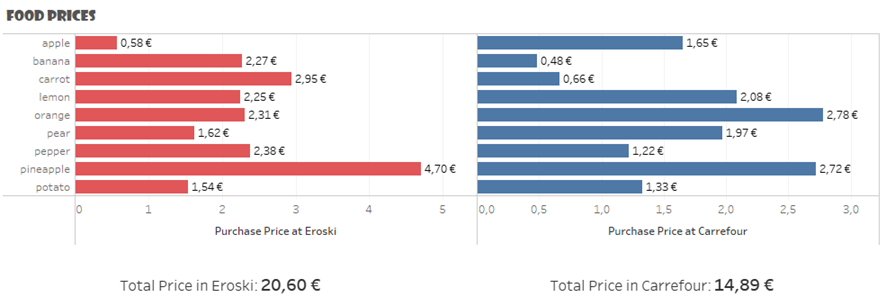